In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np

sys.path.append('./..')
sys.path.append('./../..')
sys.path.append('./../../..')

import torch
from torch import FloatTensor as FT
from torch import LongTensor as LT
from torch import nn
from torch.nn import functional as F
import os
from collections import OrderedDict
import math
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.distributions.normal import Normal
import math
from sklearn.cluster import MiniBatchKMeans, KMeans
import yaml
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher


from  model_dcn import DCN

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda


In [3]:
    
EPSILON = math.pow(10, -6)
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
print('=========================== ')

Current device  >>  cuda:2


In [4]:
def train_model(
    DATA_SET,
    data_dict,
    config
):
    global DEVICE
    print('DEVICE ',DEVICE)
    layer_dims = config[DATA_SET]['layer_dims']
    train_df = data_dict['train']
    train_X = train_df.values
    data_dim = train_X.shape[1]

    epochs_1 = config[DATA_SET]['epochs_1']
    epochs_2 = config[DATA_SET]['epochs_2']
    K = config[DATA_SET]['k']
    dcn_obj = DCN(
        DEVICE,
        data_dim,
        layer_dims,  # Provide the half (encoder only)
        op_activation='sigmoid',
        layer_activation='sigmoid',
        dropout=0.1,
        LR=0.05,
        num_epochs_1=epochs_1,
        num_epochs_2=epochs_2,
        min_epochs=5,
        batch_size=512,
        k=K,
        stop_threshold=0.05,
        checkpoint_dir=DATA_SET,
        Lambda=0.1
    )
    dcn_obj.train_model(train_X)
    print(dcn_obj.centroids)
    return dcn_obj

In [5]:
def test_eval(
    dcn_obj,
    data_dict,
    num_anomaly_sets
):
    test_X = data_dict['test'].values
    test_labels = [0 for _ in range(test_X.shape[0])]
    test_scores = dcn_obj.score_samples(test_X)
    auc_list = []

    for idx in range(num_anomaly_sets):
        key = 'anom_' + str(idx+1)
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_scores = dcn_obj.score_samples(anom_X)

        combined_scores = np.concatenate([anom_scores, test_scores], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)

        res_data = []
        for i, j in zip(combined_scores, combined_labels):
            res_data.append((i, j))
        res_df = pd.DataFrame(res_data, columns=['score', 'label'])

        #  Normalize values
        def _normalize_(val, _min, _max):
            return (val - _min) / (_max - _min)


        _max = max(combined_scores)
        _min = min(combined_scores)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min, _max,)
        )

        res_df = res_df.sort_values(by=['score'], ascending=False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min) / 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh >= _min:
            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0:
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1]
            prec = len(correct) / len(sel)
            rec = len(correct) / num_anomalies
            P.append(prec)
            R.append(rec)
            if rec >= 1.0 :
                break
            thresh -= step
            thresh = round(thresh,3)
        P = [P[0]] + P
        from sklearn.metrics import auc

        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass

    _mean = np.mean(auc_list)
    _std = np.std(auc_list)
    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return _mean, _std

In [6]:
DATA_SET = 'kddcup'
config_file = 'config.yaml'

with open(config_file, 'r') as fh:
    config = yaml.safe_load(fh)

num_anomaly_sets = config[DATA_SET]['num_anomaly_sets']
anomaly_ratio = config[DATA_SET]['anomaly_ratio']
results = []


data_dict, _ = data_fetcher.get_data(
    DATA_SET,
    one_hot=True,
    num_anom_sets=num_anomaly_sets,
    anomaly_ratio=anomaly_ratio
)

In [11]:
dcn_obj = train_model(DATA_SET, data_dict, config)

Current device  >>  cuda
DEVICE  cuda:2
Adding layer index  0
Adding layer index  1
Adding layer index  2
>>> module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=116, out_features=60, bias=True)
      (1): Sigmoid()
    )
    (1): Sequential(
      (0): Linear(in_features=60, out_features=30, bias=True)
      (1): Sigmoid()
    )
    (2): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): Sigmoid()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=30, bias=True)
      (1): Sigmoid()
    )
    (1): Sequential(
      (0): Linear(in_features=30, out_features=60, bias=True)
      (1): Sigmoid()
    )
    (2): Sequential(
      (0): Linear(in_features=60, out_features=116, bias=True)
      (1): Sigmoid()
    )
  )
)
Optimizer  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
In init_ce

  0%|          | 0/20 [00:00<?, ?it/s]

[[0.9373778  0.44621    0.2782578  0.5380747  0.69155264 0.9296098
  0.3468397  0.8608995  0.55631244 0.79708153]
 [0.07267552 0.28962365 0.09119094 0.12342767 0.19994697 0.03145273
  0.19477253 0.1673521  0.1768133  0.01661569]
 [0.9440786  0.4556857  0.7141859  0.3519786  0.35156384 0.6950478
  0.61491746 0.81135374 0.48943862 0.858854  ]
 [0.5023389  0.6845683  0.5788734  0.9370956  0.41087258 0.6930647
  0.65126413 0.63337976 0.36294878 0.16414127]
 [0.1910169  0.6197666  0.30769652 0.1681009  0.8260582  0.44970447
  0.3143441  0.51196086 0.81565017 0.04843181]]
Exiting init_centroids
<------------->
Epoch :: 1
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(148.7398, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 14.899020
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(76.8498, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(32.3697, device='cuda:2', grad_fn=<SumBack

  5%|▌         | 1/20 [00:06<02:08,  6.77s/it]

Network parameters updated
torch.Size([510, 116])
Step 2
 Clustering loss  tensor(0.2476, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Epoch :: 2
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2753, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.759899
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3408, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3276, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2605, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2954, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2937, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 10%|█         | 2/20 [00:23<02:56,  9.78s/it]

Network parameters updated
torch.Size([510, 116])
Step 2
 Clustering loss  tensor(0.2934, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Epoch :: 3
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3132, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.713950
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2911, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2256, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3245, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3418, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.3074, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 15%|█▌        | 3/20 [00:49<04:08, 14.63s/it]

Network parameters updated
Epoch :: 4
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.5668, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.714263
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.5980, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.6408, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.6578, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.5735, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.5282, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.5500, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 20%|██        | 4/20 [01:24<05:32, 20.79s/it]

Network parameters updated
Epoch :: 5
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2368, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.637149
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2640, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2154, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2486, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2585, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2322, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2256, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 25%|██▌       | 5/20 [02:11<07:08, 28.60s/it]

Network parameters updated
Epoch :: 6
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1755, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 1.147980
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1606, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2086, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1855, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1624, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1975, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2056, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 30%|███       | 6/20 [03:07<08:37, 36.96s/it]

Network parameters updated
Epoch :: 7
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1077, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.990033
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0923, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1128, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0971, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1105, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1270, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1289, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 35%|███▌      | 7/20 [04:13<09:51, 45.48s/it]

Network parameters updated
Epoch :: 8
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1844, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.862464
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1750, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1741, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1475, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1591, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1416, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1403, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 40%|████      | 8/20 [05:28<10:53, 54.43s/it]

Network parameters updated
Epoch :: 9
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1281, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.922071
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1358, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1481, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1474, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1691, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2085, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1689, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 

 45%|████▌     | 9/20 [06:50<11:29, 62.72s/it]

Network parameters updated
Epoch :: 10
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0793, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.740057
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0795, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0902, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0721, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0934, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0896, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0912, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 50%|█████     | 10/20 [08:21<11:50, 71.10s/it]

Network parameters updated
Epoch :: 11
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0847, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.907016
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1123, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0818, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0788, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0792, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0727, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0774, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 55%|█████▌    | 11/20 [09:59<11:52, 79.14s/it]

Network parameters updated
Epoch :: 12
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0728, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.884695
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0691, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0688, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0667, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0727, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0724, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0641, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 60%|██████    | 12/20 [11:44<11:35, 86.97s/it]

Network parameters updated
Epoch :: 13
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1359, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.769577
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1687, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1512, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1516, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1739, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1541, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1422, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 65%|██████▌   | 13/20 [13:37<11:02, 94.68s/it]

Network parameters updated
Epoch :: 14
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0745, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.926047
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0778, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0678, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0745, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0707, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0769, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0720, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 70%|███████   | 14/20 [15:38<10:15, 102.54s/it]

Network parameters updated
Epoch :: 15
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2146, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.825629
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2093, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2193, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2064, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.2396, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1860, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1966, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 75%|███████▌  | 15/20 [17:47<09:12, 110.51s/it]

Network parameters updated
Epoch :: 16
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0722, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.745503
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0797, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0816, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0813, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0804, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0714, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0741, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 80%|████████  | 16/20 [20:05<07:55, 118.96s/it]

Network parameters updated
Epoch :: 17
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0632, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.503472
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0713, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0723, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0728, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0721, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0665, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0631, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 85%|████████▌ | 17/20 [22:33<06:22, 127.63s/it]

Network parameters updated
Epoch :: 18
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1149, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.772334
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1155, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1139, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1303, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1322, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1424, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.1377, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 90%|█████████ | 18/20 [25:08<04:31, 135.85s/it]

Network parameters updated
Epoch :: 19
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0707, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.642904
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0673, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0689, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0707, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0695, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0670, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0854, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


 95%|█████████▌| 19/20 [27:53<02:24, 144.42s/it]

Network parameters updated
Epoch :: 20
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0581, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
Loss 0.570441
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0612, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0564, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0696, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0556, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0684, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2
 Clustering loss  tensor(0.0554, device='cuda:2', grad_fn=<SumBackward1>)
Network parameters updated
torch.Size([512, 116])
Step 2


100%|██████████| 20/20 [30:45<00:00, 92.26s/it] 

Network parameters updated
Breaking training loss staying same 
Final centroids  tensor([[8.7237e-01, 9.5193e-01, 3.2245e-01, 9.2196e-02, 1.1183e-01, 8.9282e-01,
         6.4313e-01, 9.9198e-01, 3.8042e-01, 8.9332e-01],
        [6.5222e-07, 9.9651e-01, 1.2602e-03, 3.4891e-03, 1.3430e-03, 9.8539e-01,
         6.4725e-01, 9.9834e-01, 9.1628e-01, 1.8065e-07],
        [6.2434e-01, 9.9721e-01, 8.9590e-03, 5.1093e-03, 9.6353e-03, 9.9934e-01,
         9.9971e-01, 9.9945e-01, 9.9331e-01, 9.1756e-02],
        [8.6906e-03, 9.9503e-01, 2.2325e-02, 6.0448e-02, 1.2243e-02, 9.9859e-01,
         9.9247e-01, 9.9947e-01, 9.8536e-01, 8.5602e-03],
        [2.5849e-04, 9.9845e-01, 2.7292e-03, 1.2188e-02, 2.2890e-02, 9.9338e-01,
         9.8322e-01, 9.9629e-01, 9.9259e-01, 1.5301e-03]], device='cuda:2',
       grad_fn=<SubBackward0>)
tensor([[8.7237e-01, 9.5193e-01, 3.2245e-01, 9.2196e-02, 1.1183e-01, 8.9282e-01,
         6.4313e-01, 9.9198e-01, 3.8042e-01, 8.9332e-01],
        [6.5222e-07, 9.9651e-01, 1.2

  0%|          | 0/58 [00:00<?, ?it/s]

Current device  >>  cuda


100%|██████████| 12/12 [00:00<00:00, 413.67it/s]


AUC : 0.8058 


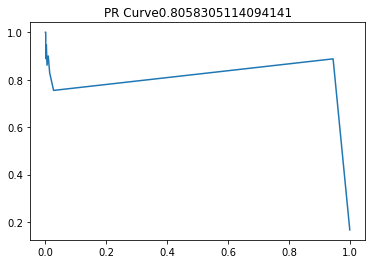

100%|██████████| 12/12 [00:00<00:00, 629.85it/s]


AUC : 0.7246 


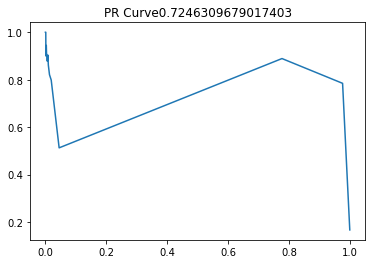

100%|██████████| 12/12 [00:00<00:00, 630.11it/s]


AUC : 0.7305 


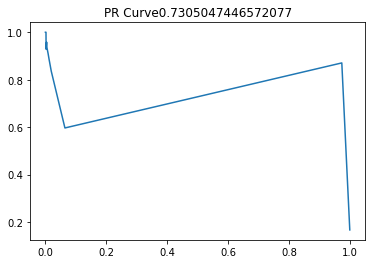

100%|██████████| 12/12 [00:00<00:00, 647.94it/s]


AUC : 0.7746 


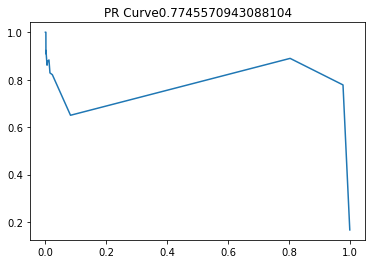

100%|██████████| 12/12 [00:00<00:00, 632.45it/s]


AUC : 0.8754 


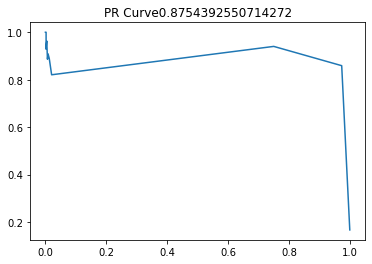

 Mean AUC  0.7821925146697198
 AUC std 0.055311782406076246


In [12]:
mean_aupr, std = test_eval(dcn_obj, data_dict, num_anomaly_sets)



(10000, 76)

In [6]:
data_dim = train_X.shape[1]
layer_dims = [64,32,16,4]

In [7]:
dcn_obj = DCN(
        DEVICE,
        data_dim,
        layer_dims,  # Provide the half (encoder only)
        op_activation='sigmoid',
        layer_activation='sigmoid',
        dropout=0.005,
        LR=0.05,
        num_epochs_1=25,
        num_epochs_2=100,
        min_epochs = 20,
        batch_size=512,
        k=5,
        stop_threshold=0.05,
        checkpoint_dir=DATA_SET,
        Lambda = 0.001
    )

In [ ]:
dcn_obj.train_model(train_X)

Adding layer index  0
Adding layer index  1
Adding layer index  2
Adding layer index  3
In init_centroids


  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
idx = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0]
])


idx = FT(idx)


In [30]:
c = FT(dcn_obj.centroids)
dcn_obj.centroids

array([[0.16499129, 0.23580414, 0.33488992, 0.06355508],
       [0.11445248, 0.29347017, 0.9099661 , 0.87875825],
       [0.7070779 , 0.56847817, 0.40286165, 0.85527784],
       [0.72176766, 0.14774324, 0.3654089 , 0.2072641 ],
       [0.24768673, 0.9049612 , 0.614901  , 0.29580304]], dtype=float32)

In [33]:
c[torch.max(idx,dim=1,keepdim=False)[1]]

tensor([[0.1650, 0.2358, 0.3349, 0.0636],
        [0.1145, 0.2935, 0.9100, 0.8788],
        [0.7218, 0.1477, 0.3654, 0.2073],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.7218, 0.1477, 0.3654, 0.2073],
        [0.2477, 0.9050, 0.6149, 0.2958],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.2477, 0.9050, 0.6149, 0.2958],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.7218, 0.1477, 0.3654, 0.2073],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.1650, 0.2358, 0.3349, 0.0636],
        [0.2477, 0.9050, 0.6149, 0.2958],
        [0.1145, 0.2935, 0.9100, 0.8788],
        [0.7071, 0.5685, 0.4029, 0.8553]])

In [172]:
p3 = p2 - dec_obj.mu

In [173]:
p3 = p3**2
p4 = torch.reciprocal(1 + torch.sum(p3,dim=-1))
p4

tensor([[0.3357, 0.4071, 0.4718, 0.3362, 0.5547],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3361, 0.4076, 0.4723, 0.3366, 0.5553],
        [0.3351, 0.4062, 0.4711, 0.3355, 0.5538],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3351, 0.4063, 0.4711, 0.3355, 0.5538],
        [0.3370, 0.4090, 0.4738, 0.3378, 0.5571]], device='cuda:0',
       grad_fn=<ReciprocalBackward>)

In [174]:
p5 = torch.sum(p4,dim=1,keepdim=True)
p5

tensor([[2.1055],
        [2.1018],
        [2.1018],
        [2.1018],
        [2.1078],
        [2.1017],
        [2.1018],
        [2.1017],
        [2.1018],
        [2.1147]], device='cuda:0', grad_fn=<SumBackward1>)

In [175]:
p4/p5

tensor([[0.1595, 0.1933, 0.2241, 0.1597, 0.2634],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1594, 0.1934, 0.2241, 0.1597, 0.2634],
        [0.1594, 0.1933, 0.2242, 0.1596, 0.2635],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1595, 0.1933, 0.2241, 0.1596, 0.2635],
        [0.1594, 0.1934, 0.2241, 0.1597, 0.2635]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [148]:
res= dec_obj.get_cluster(train_X)

 0 >>>   tensor([[[0.1409, 0.6232, 0.0770, 0.4540],
         [0.5471, 0.4537, 0.1171, 0.5279],
         [0.5825, 0.5241, 0.4331, 0.3317],
         [0.1443, 0.4036, 0.2435, 0.3860],
         [0.6486, 0.5596, 0.5561, 0.4239]],

        [[0.1409, 0.6232, 0.0770, 0.4540],
         [0.5471, 0.4537, 0.1171, 0.5279],
         [0.5825, 0.5241, 0.4331, 0.3317],
         [0.1443, 0.4036, 0.2435, 0.3860],
         [0.6486, 0.5596, 0.5561, 0.4239]],

        [[0.1409, 0.6232, 0.0770, 0.4540],
         [0.5471, 0.4537, 0.1171, 0.5279],
         [0.5825, 0.5241, 0.4331, 0.3317],
         [0.1443, 0.4036, 0.2435, 0.3860],
         [0.6486, 0.5596, 0.5561, 0.4239]],

        [[0.1409, 0.6232, 0.0770, 0.4540],
         [0.5471, 0.4537, 0.1171, 0.5279],
         [0.5825, 0.5241, 0.4331, 0.3317],
         [0.1443, 0.4036, 0.2435, 0.3860],
         [0.6486, 0.5596, 0.5561, 0.4239]],

        [[0.1409, 0.6232, 0.0770, 0.4540],
         [0.5471, 0.4537, 0.1171, 0.5279],
         [0.5825, 0.5241, 0.4331, 0.3

In [61]:
a = FT(np.array( [[0.1,0.25],[-0.25,-1]]))
a


tensor([[ 0.1000,  0.2500],
        [-0.2500, -1.0000]])

In [63]:
b = FT( np.array(
    [
        [0.35,0.75],
        [2.50,1.50],
        [6.05,7.05]
    ]
))

b1 = b.repeat([1,2]).reshape([-1,2,2])
b1

tensor([[[0.3500, 0.7500],
         [0.3500, 0.7500]],

        [[2.5000, 1.5000],
         [2.5000, 1.5000]],

        [[6.0500, 7.0500],
         [6.0500, 7.0500]]])

In [64]:
a - b1

tensor([[[-0.2500, -0.5000],
         [-0.6000, -1.7500]],

        [[-2.4000, -1.2500],
         [-2.7500, -2.5000]],

        [[-5.9500, -6.8000],
         [-6.3000, -8.0500]]])

In [69]:
mask = LT(
[[0,1],[1,0],[0,1]]
)
mask

tensor([[0, 1],
        [1, 0],
        [0, 1]])

In [73]:
c = a -b1
c.shape

torch.Size([3, 2, 2])

In [78]:
mask.repeat(1,1,2).reshape([-1,2,2]).permute([0,2,1])

tensor([[[0, 0],
         [1, 1]],

        [[1, 1],
         [0, 0]],

        [[0, 0],
         [1, 1]]])

In [79]:
mask.repeat(1,1,2).reshape([-1,2,2]).permute([0,2,1]) *  c

tensor([[[-0.0000, -0.0000],
         [-0.6000, -1.7500]],

        [[-2.4000, -1.2500],
         [-0.0000, -0.0000]],

        [[-0.0000, -0.0000],
         [-6.3000, -8.0500]]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f27ee0a63d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27ee0a6e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f27ee094e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f27ee0cb950>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f27ee0cbe90>],
 'means': []}

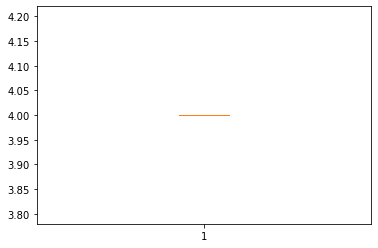

In [130]:
plt.boxplot(res)

In [1]:
import numpy as np

arr = [
    0.813183,0.808922,0.887566 ,0.899111, 0.924414, 0.893159,  0.952520, 0.911151,  0.920062 ,  0.922320
]
np.mean(arr),np.std(arr)
        

(0.8932407999999998, 0.044673397593646275)